<a href="https://colab.research.google.com/github/changyong93/Natural-language-processing-with-chat-bot/blob/main/%EC%B1%97%EB%B4%87_%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5(hotel_ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CRF 사용을 위한 텐서플로우 버전 조정

In [1]:
#==과 버전 사이에 띄어쓰기 없이 그대로 사용
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0
!pip install git+https://www.github.com/keras-team/keras-contrib.git


     |████████████████████████████████| 109.3MB 37kB/s 
     |████████████████████████████████| 491kB 49.4MB/s 
     |████████████████████████████████| 3.2MB 54.1MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 317kB 10.0MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 377.1MB 44kB/s 
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-12ssaejl
  Running command git clone -q 

# 사전 추가를 위한 형태소 분석기 Mecab-ko 설치

In [2]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [3]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [4]:
!bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 9.0MB/s 
     |████████████████████████████████| 460kB 55.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-04-20 05:27:25--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=pXZRErrFFCmmFB9%2FScJkScThXSw%3D&Expires=1618897535&AWSAccessKeyId=AKIA6KOSE3B

# 규칙정의

의도는 총 5가지

In [5]:
#예약(예약, 평점기준 추천 등) / 변경 / 취소 / 확인 / 정보(체크인, 체크아웃, 시설 등) 

# 예약 => 호텔스 컴바인 체크인 및 아웃 날짜 기준으로 가능한 방 및 추천방 전달
# xx 지역 이용 가능한 방 있어 / xx호텔 xx지역 빙 방 있어? / 내일 xx지역 이용 가능한 방 있어?? / xx지역 평점 기준으로 방 추천해줘

# 변경 => 호텔스컴바인은 가격비교 사이트로 처리 불가. 고객이 실제 이용한 결제 페이지나 해당 호텔 연락처 전달
# xxxx 번호 방 변경해줘 / xxxx호텔에 예약한 거 방 변경해줘 / xxxx호텔 예약한 거 이용 날짜 변경해줘 / xxxx번호 방 날짜 변경할래

# 취소 => 호텔스컴바인은 가격비교 사이트로 처리 불가. 고객이 실제 이용한 결제 페이지나 해당 호텔 연락처 전달
# xxxx 번호 취소해줘 / xxxx호텔 예약 취소해줘 / xxxx 번호 취소할게요 / xxxx번호 취소

# 확인 => 호텔스컴바인은 가격비교 사이트로 처리 불가. 고객이 실제 이용한 결제 페이지나 해당 호텔 연락처 전달
# xxxx 번호 예약 확인해줘 / xxxx 번호 예약 확인

# 정보
# xxxx 호텔 체크인 or 체크아웃 시간 언제야 / xxxx호텔 입실 or 퇴실 시간 언제야 / xxxx호텔 입퇴실 시간 언제야 / xxxx호텔 체크인 및 체크아웃 시간 언제야
# xxxx 호텔 이용가능한 시설 뭐 있어 / xxxx호텔 반려견 동반 가능해? / xxxx호텔 서비스 뭐 있어?

개체명은 아래와 같이 규칙을 정한다

In [6]:
#규칙
"""
총 8개의 태그
SEA : 검색
FAC : 시설(체크인,체크아웃,서비스 등 모두 포함)
GRA : 평점
PRI : 가격
CHA : 변경
CAN : 취소
CHE : 확인, 체크
RES : 예약 (불필요한 것 같음..)
DAT : 날짜(내일, 모레, 일주일 뒤, 한달 뒤, 4월30일, 5월15일, 5/15)
"""

'\n총 8개의 태그\nSEA : 검색\nFAC : 시설(체크인,체크아웃,서비스 등 모두 포함)\nGRA : 평점\nPRI : 가격\nCHA : 변경\nCAN : 취소\nCHE : 확인, 체크\nRES : 예약 (불필요한 것 같음..)\nDAT : 날짜(내일, 모레, 일주일 뒤, 한달 뒤, 4월30일, 5월15일, 5/15)\n'

## 호텔명 및 지역명 불러오기
- hotelscombind에서 지역별로 호텔명을 가져옴
- 호텔스컴바인은 전체 리스트가 아닌, 지정한 조건(체크인, 체크아웃, 객실수, 이용객 수)에 따라 조건이 달라짐
- 해당 데이터는 4.17~4.18 객실 1개, 이용객 2명 기준으로 각 지역별로 호텔명을 크롤링
- colab에서 selenium을 이용한 크롤링에 제한사항(사용법을 잘 모름)으로 우선 local의 jupyter notebook에서 크롤링 진행  
---
- 지역명은 각 지역(서울,서귀포 등)에서 호텔스컴바인 기준으로 가져옴
  https://www.hotelscombined.co.kr/Place/Seoul.htm

In [7]:
import os
os.listdir()

['images',
 '.git',
 '.DS_Store',
 'install_mecab-ko_on_colab_light_210108.sh',
 'install_mecab-ko_on_colab190912.sh',
 'LICENSE',
 'README.md']

In [30]:
#로컬 파일 가져오지
# from google.colab import files
# myfile1 = files.upload() #hotel_list
# myfile2 = files.upload() #location_list

# import pandas as pd 
#구글 드라이브에 저장된 파일 활용
# data = pd.read_csv("hotel_list.csv")
# data_loc = pd.read_csv("location_list.csv")

#상기 코드가 에러날 경우, io를 활용하여 pandas module 사용
# import io
# data = pd.read_csv(io.BytesIO(myfile1['hotel_list.csv']))
# data_loc = pd.read_csv(io.BytesIO(myfile2['location_list.csv']))

import google
google.colab.drive.mount('/content/gdrive/')
data =  pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/hotel_list.csv")
data_loc =  pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/location_list.csv")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [31]:
data.head()

,Unnamed: 0,지역,호텔
0,0,서울,신라스테이 광화문
1,1,서울,신라스테이 역삼
2,2,서울,글래드 여의도
3,3,서울,글래드 강남 코엑스센터
4,4,서울,신라스테이 서대문


In [32]:
data = data[["호텔","지역"]].copy()
data.shape

(3332, 2)

In [33]:
data["호텔"].nunique(),data['지역'].nunique()

(3221, 15)

In [34]:
#중복값 제거
data = data.drop_duplicates(subset = ["호텔"])
data.shape

(3221, 2)

In [35]:
hotel_list = data["호텔"].to_list()
print(hotel_list)

['신라스테이 광화문', '신라스테이 역삼', '글래드 여의도', '글래드 강남 코엑스센터', '신라스테이 서대문', '신라스테이 서초', '나인트리 프리미어 호텔 인사동', '나인트리 프리미어 호텔 명동 2', '글래드 마포', 'L7 강남 바이 롯데', '오라카이 청계산 호텔', '시그니엘 서울', '신라스테이 삼성', '인터컨티넨탈 서울 코엑스', '롯데시티호텔 명동', '호텔 안테룸 서울', '호텔 스카이파크 킹스타운 동대문', '신라스테이 마포', '라마다 서울 호텔', '서울가든호텔', '서울 신라 호텔', '롯데시티호텔 구로', '신라스테이 구로', '오라카이 대학로 호텔', '나인트리 호텔 동대문', '라마다 서울 신도림', '티마크 그랜드 호텔 명동', '페어필드 바이 메리어트 서울', '호텔 리베라 서울', '노보텔 앰배서더 서울 용산', '그랜드 인터컨티넨탈 서울 파르나스', '쉐라톤 서울 디큐브시티 호텔', '오클라우드 호텔', '롯데 호텔 월드', '라마다 앙코르 서울 마곡', '그랜드 하얏트 서울', '임피리얼 팰리스 서울', '몬드리안 서울 이태원', 'L7 홍대 바이 롯데', '메이필드 호텔 서울', '호텔 더 디자이너스 서울역점', '콘래드 서울 호텔', '롯데시티호텔 마포', '호텔 루체브릿지', '오라카이 인사동 스위트', '아리랑힐 호텔 동대문', '도미인 서울 강남', '레스케이프 호텔', '스탠포드 호텔 서울', '롯데시티호텔 김포공항', 'PJ 호텔 명동 (피제이 호텔)', '그랜드 워커힐 서울 (구, 쉐라톤 그랜드 워커힐 서울)', '노보텔 스위트 앰배서더 서울 용산', '라이즈 오토그래프 컬렉션 바이 메리어트', '홀리데이 인 익스프레스 서울 홍대', '로사나 부띠끄 비즈니스 호텔', '호텔 인 9 강남', '호텔 파크하비오', '호텔 페이토 삼성', '로얄스퀘어호텔 서울', '서머셋 팰리스 서울', '코리아나 호텔', '오크우드 프리미어 코엑스센터', '노보텔 앰배서더 서울 동대문', '호텔 엠펠리체', '프리마 

In [36]:
print(data_loc.shape)
print("*"*30)
print(data_loc.nunique())

(132, 1)
******************************
지역    108
dtype: int64


In [37]:
data_loc = data_loc.drop_duplicates()
data_loc[20:30]

,지역
20,남대문
21,4호선 혜화역
22,올림픽공원
23,2호선 삼성역
24,동대문 종합시장
25,고려대학교
26,Jamsil Sports Complex
27,청계천
28,서귀포
29,제주시 제주 국제 공항


In [38]:
data_loc.loc[data_loc["지역"]=="Jamsil Sports Complex","지역"] = "잠실종합운동장"
data_loc[20:30]

,지역
20,남대문
21,4호선 혜화역
22,올림픽공원
23,2호선 삼성역
24,동대문 종합시장
25,고려대학교
26,잠실종합운동장
27,청계천
28,서귀포
29,제주시 제주 국제 공항


In [39]:
location_list = data_loc["지역"].to_list()
print(location_list)

['서울', '인천 국제 공항', '서울 김포 국제공항', '강서구', '서초구', '강동구', '동대문구', '종로구', '은평구', '서대문구', '영등포구', '마포구', '강북구', '롯데월드', '광화문', '홍대거리', '경복궁', '북촌 한옥마을', '홍대 앞', '코엑스', '남대문', '4호선 혜화역', '올림픽공원', '2호선 삼성역', '동대문 종합시장', '고려대학교', '잠실종합운동장', '청계천', '서귀포', '제주시 제주 국제 공항', '제주 중문 관광단지', '섭지코지', '천지연폭포', '아쿠아플라넷 제주', '제주 월드컵 경기장', '서귀포 매일 올레시장', '제주 산방산탄산온천', '표선 해비치 해변', '성산항', '여수', '부산 김해 국제 공항', '대구', '무안 국제 공항', '양양', '양양 국제 공항', '낙산사', '평창', '보광 휘닉스파크', '용평 스키 리조트', '둔내자연휴양림', '제주시', '함덕 해수욕장', '제주 협재 해수욕장', '한라산 국립공원', '동문시장', '월정리 해수욕장', '탑동광장', '곽지 해수욕장', '한라산', '용두암', '이호 해변', '김녕해수욕장', '한림공원', '세화 해수욕장', '강릉', '강릉 경포대', '경포해수욕장', '주문진항', '강릉 주문진 해수욕장', '강릉 정동진 해돋이공원', '인천', '인천 을왕리 해수욕장', '월미도', '송도 컨벤시아', '센트럴파크', '인천 차이나 타운', '공항철도 운서역', '인천 1호선 인천터미널역', '공항철도인천국제공항역', '거제', '통영', '부산', '광안리 해수욕장', '해운대 해수욕장', '서면', '부산 1, 2호선 서면역', '부산 2호선 해운대역', '벡스코', '광안대교', '부산 자갈치 시장', '경부선 부산역', '국제시장', '부산대학교', '부산2호선 벡스코역', '태종대', '부산 2호선 광안역', '부산역 광장', '속초', '대포항', '속초설악파인리조트', '경주', '경주 월드 

## 학습 데이터 만들기

### 형태소 분석기 사전 추가할 데이터 정리(호텔)

In [40]:
from konlpy.tag import Mecab
mecab = Mecab()

In [41]:
for i in range(30):
  print(f"[{i}번째] {hotel_list[i]} ===> {mecab.pos(hotel_list[i])}")
mecab.pos(hotel_list[0])

[0번째] 신라스테이 광화문 ===> [('신라', 'NNP'), ('스테이', 'NNG'), ('광화문', 'NNG')]
[1번째] 신라스테이 역삼 ===> [('신라', 'NNP'), ('스테이', 'NNG'), ('역삼', 'NNG')]
[2번째] 글래드 여의도 ===> [('글래드', 'NNP'), ('여의도', 'NNG')]
[3번째] 글래드 강남 코엑스센터 ===> [('글래드', 'NNP'), ('강남', 'NNP'), ('코엑스센터', 'NNP')]
[4번째] 신라스테이 서대문 ===> [('신라', 'NNP'), ('스테이', 'NNG'), ('서대문', 'NNG')]
[5번째] 신라스테이 서초 ===> [('신라', 'NNP'), ('스테이', 'NNG'), ('서초', 'NNG')]
[6번째] 나인트리 프리미어 호텔 인사동 ===> [('나', 'NP'), ('인', 'VCP+ETM'), ('트리', 'NNG'), ('프리미어', 'NNP'), ('호텔', 'NNG'), ('인사동', 'NNP')]
[7번째] 나인트리 프리미어 호텔 명동 2 ===> [('나', 'NP'), ('인', 'VCP+ETM'), ('트리', 'NNG'), ('프리미어', 'NNP'), ('호텔', 'NNG'), ('명동', 'NNG'), ('2', 'SN')]
[8번째] 글래드 마포 ===> [('글래드', 'NNP'), ('마포', 'NNG')]
[9번째] L7 강남 바이 롯데 ===> [('L', 'SL'), ('7', 'SN'), ('강남', 'NNP'), ('바이', 'NNP'), ('롯데', 'NNP')]
[10번째] 오라카이 청계산 호텔 ===> [('오라', 'IC'), ('카이', 'NNP'), ('청계산', 'NNP'), ('호텔', 'NNG')]
[11번째] 시그니엘 서울 ===> [('시그', 'NNP'), ('니엘', 'NNP'), ('서울', 'NNP')]
[12번째] 신라스테이 삼성 ===> [('신라', 'NNP'), ('스테이', 'N

[('신라', 'NNP'), ('스테이', 'NNG'), ('광화문', 'NNG')]

형태소가 부정확하게 인식하는 것에 대해서 우선 사전을 추가
- 띄어쓰기 단위로 단어를 나누고, 2글자 이상만 선택 후 사전에 추가
- 한글만 선택해서 받기

In [42]:
import re
print(hotel_list[9])
print(re.sub(pattern="[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",repl = "",string = hotel_list[9]))

L7 강남 바이 롯데
 강남 바이 롯데


In [43]:
words_hotel = []
for i in range(len(hotel_list)):
  hotel_name = hotel_list[i]
  hotel_name = re.sub(pattern = "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",repl = "",string = hotel_name)
  for word in hotel_name.split():
    if (len(word) >= 2) & (word not in words_hotel):
      words_hotel.append(word)


In [44]:
print("2글자 이상의 단어 개수: ", len(words_hotel))
print("-"*30)
print(words_hotel)

2글자 이상의 단어 개수:  2806
------------------------------
['신라스테이', '광화문', '역삼', '글래드', '여의도', '강남', '코엑스센터', '서대문', '서초', '나인트리', '프리미어', '호텔', '인사동', '명동', '마포', '바이', '롯데', '오라카이', '청계산', '시그니엘', '서울', '삼성', '인터컨티넨탈', '코엑스', '롯데시티호텔', '안테룸', '스카이파크', '킹스타운', '동대문', '라마다', '서울가든호텔', '신라', '구로', '대학로', '신도림', '티마크', '그랜드', '페어필드', '메리어트', '리베라', '노보텔', '앰배서더', '용산', '파르나스', '쉐라톤', '디큐브시티', '오클라우드', '월드', '앙코르', '마곡', '하얏트', '임피리얼', '팰리스', '몬드리안', '이태원', '홍대', '메이필드', '디자이너스', '서울역점', '콘래드', '루체브릿지', '스위트', '아리랑힐', '도미인', '레스케이프', '스탠포드', '김포공항', '피제이', '워커힐', '라이즈', '오토그래프', '컬렉션', '홀리데이', '익스프레스', '로사나', '부띠끄', '비즈니스', '파크하비오', '페이토', '로얄스퀘어호텔', '서머셋', '코리아나', '오크우드', '엠펠리체', '프리마', '라이브', '포레힐', '토요코인', '서울강남점', '웨스틴', '조선', '스타즈', '독산점', '비스타', '뉴브', '리즈', '딜라이트', '머큐어', '쏘도베', '어반', '플레이스', '포포인츠', '켄싱턴', '밀레니엄', '힐튼', '리버사이드', '서울역', '메이플레이스', '스위트호텔', '코트야드', '타임스퀘어', '스테이', '더파크호텔', '해밀톤', '포시즌스', '엔트라', '파크', '부티크', '그레이스리', '보타닉', '유리앤', '리센츠', '프리미엄', '가로수길', '서울영등포점', '인터시티', '아벤

### 형태소 분석기 사전 추가할 데이터 정리(지역명)

In [240]:
for i in range(len(location_list)):
  print(f"[{location_list[i]}]     ", mecab.pos(location_list[i]))

[서울]      [('서울', 'NNP')]
[인천 국제 공항]      [('인천', 'NNP'), ('국제', 'NNP'), ('공항', 'NNP')]
[서울 김포 국제공항]      [('서울', 'NNP'), ('김포', 'NNP'), ('국제공항', 'NNG')]
[강서구]      [('강서구', 'NNP')]
[서초구]      [('서초구', 'NNP')]
[강동구]      [('강동구', 'NNP')]
[동대문구]      [('동대문구', 'NNP')]
[종로구]      [('종로구', 'NNP')]
[은평구]      [('은평구', 'NNP')]
[서대문구]      [('서대문', 'NNP'), ('구', 'VCP+EC')]
[영등포구]      [('영등포구', 'NNP')]
[마포구]      [('마포구', 'NNP')]
[강북구]      [('강북구', 'NNP')]
[롯데월드]      [('롯데월드', 'NNP')]
[광화문]      [('광화문', 'NNP')]
[홍대거리]      [('홍대', 'NNP'), ('거리', 'NNG')]
[경복궁]      [('경복궁', 'NNG')]
[북촌 한옥마을]      [('북촌', 'NNP'), ('한옥마을', 'NNP')]
[홍대 앞]      [('홍대', 'NNP'), ('앞', 'NNG')]
[코엑스]      [('코엑스', 'NNP')]
[남대문]      [('남대문', 'NNP')]
[4호선 혜화역]      [('4', 'SN'), ('호', 'NNBC'), ('선', 'NNG'), ('혜화', 'NNG'), ('역', 'NNG')]
[올림픽공원]      [('올림픽', 'NNP'), ('공원', 'NNG')]
[2호선 삼성역]      [('2', 'SN'), ('호', 'NNBC'), ('선', 'NNG'), ('삼', 'NR'), ('성역', 'NNG')]
[동대문 종합시장]      [('동대문', 'NNP'), ('종합', 'NNG'), ('시

In [241]:
words_location = []
for i in range(len(location_list)):
  location_name = location_list[i]
  location_name = re.sub(pattern = "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",repl = "",string = location_name)
  for word in location_name.split():
    if (len(word) >= 2) & (word not in words_location):
      words_location.append(word)

### 형태소 분석기 사전 추가할 데이터 정리(기타)

In [46]:
etc_list = ["반려견"]

words_etc = []
for i in range(len(etc_list)):
  word = etc_list[i]
  word = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", repl = "", string = word)
  if len(word) >= 2:
    words_etc.append(word)
words_etc

['반려견']

In [242]:
add_words = words_hotel + words_location + words_etc
print(len(add_words))

2935


### 형태소 분석기 사전 업데이트 후 재실행

In [243]:
# 사전 추가를 위한 경로 이동 => user-dic 의 nnp(일반명사)에 단어 단어 추가
%cd /content/mecab-ko-dic-2.1.1-20180720
%ls

/content/mecab-ko-dic-2.1.1-20180720
aclocal.m4            feature.def  model.def          sys.dic
AUTHORS               Foreign.csv  NEWS               tools/
autogen.sh*           Group.csv    NNBC.csv           unk.def
best_intent_model.h5  Hanja.csv    NNB.csv            unk.dic
ChangeLog             IC.csv       NNG.csv            user-dic/
char.bin              Inflect.csv  NNP.csv            user-nnp.csv
char.def              INSTALL      NorthKorea.csv     user-person.csv
clean*                install-sh*  NP.csv             user-place.csv
CoinedWord.csv        J.csv        NR.csv             VA.csv
config.log            left-id.def  Person-actor.csv   VCN.csv
config.status*        MAG.csv      Person.csv         VCP.csv
configure*            MAJ.csv      Place-address.csv  VV.csv
configure.ac          Makefile     Place.csv          VX.csv
COPYING               Makefile.am  Place-station.csv  Wikipedia.csv
dicrc                 Makefile.in  pos-id.def         XPN.csv
EC.csv   

In [244]:
%ls user-dic/

nnp.csv  person.csv  place.csv  README.md


In [245]:
with open("./user-dic/nnp.csv",'r') as f:
  file_data = f.readlines()

In [246]:
file_data #이미 추가했기에 늘어남

['대우,,,,NNP,*,F,대우,*,*,*,*,*\n',
 '구글,,,,NNP,*,T,구글,*,*,*,*,*\n',
 '신라스테이,,,,NNP,*,F,신라스테이,*,*,*,*,*\n',
 '광화문,,,,NNP,*,T,광화문,*,*,*,*,*\n',
 '역삼,,,,NNP,*,T,역삼,*,*,*,*,*\n',
 '글래드,,,,NNP,*,F,글래드,*,*,*,*,*\n',
 '여의도,,,,NNP,*,F,여의도,*,*,*,*,*\n',
 '강남,,,,NNP,*,T,강남,*,*,*,*,*\n',
 '코엑스센터,,,,NNP,*,F,코엑스센터,*,*,*,*,*\n',
 '서대문,,,,NNP,*,T,서대문,*,*,*,*,*\n',
 '서초,,,,NNP,*,F,서초,*,*,*,*,*\n',
 '나인트리,,,,NNP,*,F,나인트리,*,*,*,*,*\n',
 '프리미어,,,,NNP,*,F,프리미어,*,*,*,*,*\n',
 '호텔,,,,NNP,*,T,호텔,*,*,*,*,*\n',
 '인사동,,,,NNP,*,T,인사동,*,*,*,*,*\n',
 '명동,,,,NNP,*,T,명동,*,*,*,*,*\n',
 '마포,,,,NNP,*,F,마포,*,*,*,*,*\n',
 '바이,,,,NNP,*,F,바이,*,*,*,*,*\n',
 '롯데,,,,NNP,*,T,롯데,*,*,*,*,*\n',
 '오라카이,,,,NNP,*,F,오라카이,*,*,*,*,*\n',
 '청계산,,,,NNP,*,T,청계산,*,*,*,*,*\n',
 '시그니엘,,,,NNP,*,T,시그니엘,*,*,*,*,*\n',
 '서울,,,,NNP,*,T,서울,*,*,*,*,*\n',
 '삼성,,,,NNP,*,T,삼성,*,*,*,*,*\n',
 '인터컨티넨탈,,,,NNP,*,T,인터컨티넨탈,*,*,*,*,*\n',
 '코엑스,,,,NNP,*,F,코엑스,*,*,*,*,*\n',
 '롯데시티호텔,,,,NNP,*,T,롯데시티호텔,*,*,*,*,*\n',
 '안테룸,,,,NNP,*,T,안테룸,*,*,*,*,*\n',
 '스카이파크,,,,NNP,*

In [247]:
#단어 추가를 위해선 마지막 글자의 종성여부 판단이 필요
#관련 패키지 설치
!pip install jamo

In [248]:
from jamo import h2j, j2hcj #종성 여부를 판단해주는 
#h2j => 조합형 한글로 바꾼 다음
#j2hcj => 완성형 한글로 바꾸기
j2hcj(h2j(add_words[0]))

'ㅅㅣㄴㄹㅏㅅㅡㅌㅔㅇㅣ'

In [249]:
T_jamo = []
def get_jongsung_TF(sample_text):
  sample_text_list = list(sample_text)
  last_word = sample_text_list[-1]
  last_word_jamo_list = list(j2hcj(h2j(last_word)))
  last_jamo = last_word_jamo_list[-1]

  #마지막 종성이 모음일 경우 T
  jongsung_TF = "T"

  #마지막 종성이 자음일 경우, 즉 입력한 단어에 받침이 있는 경우 F
  if last_jamo in ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅘ', 'ㅚ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ', 'ㅐ,ㅔ', 'ㅟ', 'ㅖ', 'ㅒ']:
    jongsung_TF = "F"
  
  return jongsung_TF

In [250]:
for i in range(10):
  print(f"글자: {add_words[i]:10} 받침 유무: {get_jongsung_TF(add_words[i])}")

글자: 신라스테이      받침 유무: F
글자: 광화문        받침 유무: T
글자: 역삼         받침 유무: T
글자: 글래드        받침 유무: F
글자: 여의도        받침 유무: F
글자: 강남         받침 유무: T
글자: 코엑스센터      받침 유무: F
글자: 서대문        받침 유무: T
글자: 서초         받침 유무: F
글자: 나인트리       받침 유무: F


In [254]:
#사전 추가
with open("./user-dic/nnp.csv","r") as f:
  file_data = f.readlines()

for word in add_words:
  jongsung_TF = get_jongsung_TF(word)

  # line = f"{word},,,,NNP,*,{jongsung_TF},{word},*,*,*,*,*\n"
  
  # 사전을 새로 추가했더라도 기존과 같이 출력된 경우 ex) 반려견 => 반려, 견
  line = f"{word},,,0,NNP,*,{jongsung_TF},{word},*,*,*,*,*\n"
  #사전 입력 시 0이 입력된 부분이 우선순위 지정
  #유사한 단어가 기존 사전에 포함된 경우 우선순위에 따라 결과가 출력됨
  

  file_data.append(line)

In [255]:
# 사전 작성
with open("./user-dic/nnp.csv","w") as f:
  for line in file_data:
    f.write(line)

In [256]:
# 사전 작성 후 다시 읽기
with open("./user-dic/nnp.csv","r") as f:
  file_new = f.readlines()
file_new

['대우,,,,NNP,*,F,대우,*,*,*,*,*\n',
 '구글,,,,NNP,*,T,구글,*,*,*,*,*\n',
 '신라스테이,,,,NNP,*,F,신라스테이,*,*,*,*,*\n',
 '광화문,,,,NNP,*,T,광화문,*,*,*,*,*\n',
 '역삼,,,,NNP,*,T,역삼,*,*,*,*,*\n',
 '글래드,,,,NNP,*,F,글래드,*,*,*,*,*\n',
 '여의도,,,,NNP,*,F,여의도,*,*,*,*,*\n',
 '강남,,,,NNP,*,T,강남,*,*,*,*,*\n',
 '코엑스센터,,,,NNP,*,F,코엑스센터,*,*,*,*,*\n',
 '서대문,,,,NNP,*,T,서대문,*,*,*,*,*\n',
 '서초,,,,NNP,*,F,서초,*,*,*,*,*\n',
 '나인트리,,,,NNP,*,F,나인트리,*,*,*,*,*\n',
 '프리미어,,,,NNP,*,F,프리미어,*,*,*,*,*\n',
 '호텔,,,,NNP,*,T,호텔,*,*,*,*,*\n',
 '인사동,,,,NNP,*,T,인사동,*,*,*,*,*\n',
 '명동,,,,NNP,*,T,명동,*,*,*,*,*\n',
 '마포,,,,NNP,*,F,마포,*,*,*,*,*\n',
 '바이,,,,NNP,*,F,바이,*,*,*,*,*\n',
 '롯데,,,,NNP,*,T,롯데,*,*,*,*,*\n',
 '오라카이,,,,NNP,*,F,오라카이,*,*,*,*,*\n',
 '청계산,,,,NNP,*,T,청계산,*,*,*,*,*\n',
 '시그니엘,,,,NNP,*,T,시그니엘,*,*,*,*,*\n',
 '서울,,,,NNP,*,T,서울,*,*,*,*,*\n',
 '삼성,,,,NNP,*,T,삼성,*,*,*,*,*\n',
 '인터컨티넨탈,,,,NNP,*,T,인터컨티넨탈,*,*,*,*,*\n',
 '코엑스,,,,NNP,*,F,코엑스,*,*,*,*,*\n',
 '롯데시티호텔,,,,NNP,*,T,롯데시티호텔,*,*,*,*,*\n',
 '안테룸,,,,NNP,*,T,안테룸,*,*,*,*,*\n',
 '스카이파크,,,,NNP,*

In [59]:
# 사전  추가 완료하기
%ls

aclocal.m4      EF.csv       MAJ.csv      NorthKorea.csv     tools/
AUTHORS         EP.csv       Makefile     NP.csv             unk.def
autogen.sh*     ETM.csv      Makefile.am  NR.csv             unk.dic
ChangeLog       ETN.csv      Makefile.in  Person-actor.csv   user-dic/
char.bin        feature.def  matrix.bin   Person.csv         VA.csv
char.def        Foreign.csv  matrix.def   Place-address.csv  VCN.csv
clean*          Group.csv    missing*     Place.csv          VCP.csv
CoinedWord.csv  Hanja.csv    MM.csv       Place-station.csv  VV.csv
config.log      IC.csv       model.bin    pos-id.def         VX.csv
config.status*  Inflect.csv  model.def    Preanalysis.csv    Wikipedia.csv
configure*      INSTALL      NEWS         README             XPN.csv
configure.ac    install-sh*  NNBC.csv     rewrite.def        XR.csv
COPYING         J.csv        NNB.csv      right-id.def       XSA.csv
dicrc           left-id.def  NNG.csv      Symbol.csv         XSN.csv
EC.csv          MAG.csv      NN

In [60]:
%ls tools

add-userdic.sh*  convert_for_using_store.sh*  mecab-bestn.sh*


In [61]:
!bash ./tools/add-userdic.sh

generating userdic...
nnp.csv
/content/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /content/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/nnp.csv ... 
done!
person.csv
/content/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /content/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/person.csv ... 
done!
place.csv
/content/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /content/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/place.csv ... 
done!
test -z "model.bin matrix.bin char.bin sys.dic unk.dic" || rm -f model.bin matrix.bin char.bin sys.dic unk.dic
/usr/local/libexec/mecab/mecab-dict-index -d . -o . -f UTF-8 -t UTF-8
reading ./unk.def ... 13
emitting double-array: 100% |###########################################| 
reading ./user-place.csv ... 2
reading ./MAJ.csv ... 240
reading ./Group.csv ... 3176
reading ./NNBC.c

In [62]:
!make install

make[1]: Entering directory '/content/mecab-ko-dic-2.1.1-20180720'
make[1]: Nothing to be done for 'install-exec-am'.
 /bin/mkdir -p '/usr/local/lib/mecab/dic/mecab-ko-dic'
 /usr/bin/install -c -m 644 model.bin matrix.bin char.bin sys.dic unk.dic left-id.def right-id.def rewrite.def pos-id.def dicrc '/usr/local/lib/mecab/dic/mecab-ko-dic'
make[1]: Leaving directory '/content/mecab-ko-dic-2.1.1-20180720'


In [63]:
# 정상적으로 등록된 지 재확인
from konlpy.tag import Mecab
mecab = Mecab()

for i in range(30):
  print(f"[{i}번째] {hotel_list[i]} ===> {mecab.pos(hotel_list[i])}")
mecab.pos(hotel_list[0])

[0번째] 신라스테이 광화문 ===> [('신라스테이', 'NNP'), ('광화문', 'NNP')]
[1번째] 신라스테이 역삼 ===> [('신라스테이', 'NNP'), ('역삼', 'NNP')]
[2번째] 글래드 여의도 ===> [('글래드', 'NNP'), ('여의도', 'NNP')]
[3번째] 글래드 강남 코엑스센터 ===> [('글래드', 'NNP'), ('강남', 'NNP'), ('코엑스센터', 'NNP')]
[4번째] 신라스테이 서대문 ===> [('신라스테이', 'NNP'), ('서대문', 'NNP')]
[5번째] 신라스테이 서초 ===> [('신라스테이', 'NNP'), ('서초', 'NNP')]
[6번째] 나인트리 프리미어 호텔 인사동 ===> [('나인트리', 'NNP'), ('프리미어', 'NNP'), ('호텔', 'NNP'), ('인사동', 'NNP')]
[7번째] 나인트리 프리미어 호텔 명동 2 ===> [('나인트리', 'NNP'), ('프리미어', 'NNP'), ('호텔', 'NNP'), ('명동', 'NNP'), ('2', 'SN')]
[8번째] 글래드 마포 ===> [('글래드', 'NNP'), ('마포', 'NNP')]
[9번째] L7 강남 바이 롯데 ===> [('L', 'SL'), ('7', 'SN'), ('강남', 'NNP'), ('바이', 'NNP'), ('롯데', 'NNP')]
[10번째] 오라카이 청계산 호텔 ===> [('오라카이', 'NNP'), ('청계산', 'NNP'), ('호텔', 'NNP')]
[11번째] 시그니엘 서울 ===> [('시그니엘', 'NNP'), ('서울', 'NNP')]
[12번째] 신라스테이 삼성 ===> [('신라스테이', 'NNP'), ('삼성', 'NNP')]
[13번째] 인터컨티넨탈 서울 코엑스 ===> [('인터컨티넨탈', 'NNP'), ('서울', 'NNP'), ('코엑스', 'NNP')]
[14번째] 롯데시티호텔 명동 ===> [('롯데시티호텔', 'NNP'), ('명동', '

[('신라스테이', 'NNP'), ('광화문', 'NNP')]

### 예약 종목 학습 데이터 만들기

In [202]:
import numpy as np
import random
from sklearn.utils import shuffle

In [203]:
# price_list =[] #price가 없을 경우에 약 3만개의 질문이 생성되는데, price가 여러개일 경우  질문이 백만개 단위로 생성됨, 우선 하나의 값만 적용
# for price in range(100000, 210000, 10000):
#   price_won = f"{price}원"
#   price_list.append(price)
#   price_list.append(price_won)

price_list = ["100000", "100000원"]
print(price_list)

['100000', '100000원']


In [204]:
def question_generator(hotel_list, location_list, price_list):
  """
  hotel_list : 호텔스컴바인의 호텔 리스트 기준으로 생성
  location_list : 호텔스컴바인의 지역별 세부 지역 혹은 명소 등을 기준으로 생성
  price_list : 100000~200000 사이를 기준으로 잡고 리스트 생성

  location_list & price_list가 없을 경우 hotel_list 기준으로만 질문 생성
  """
  question = []

  for hotel in hotel_list:
    for location in location_list:
      s1 = hotel + " " + location + " 이용 가능한 방 있어?"
      s2 = hotel + " " + location + " 빈 방 있어?"
      s3 = hotel + " " + location + " 묵을 방 있어?"
      s4 = hotel + " " + location + " 방 있어?"
      s5 = hotel + " " + location + " 이용 가능한 방"
      s6 = hotel + " " + location + " 내일 이용 가능해?"
      s7 = hotel + " " + location + " 모레 방 있어?"
      s8 = hotel + " " + location + " 이용 가능한 방 있어?"
      s9 = hotel + " " + location + " 빈 방 있어?"
      s10 = hotel + " " + location + " 묵을 방 있어?"
      s11 = hotel + " " + location + " 방 있어?"
      question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11]

  for price in price_list:
    for hotel in hotel_list:
      for location in location_list:
        s1 = price + " 이하 " + hotel + " " + location + " 이용 가능한 방 있어?"
        s2 = price + " 미만 " + hotel + " " + location + " 이용 가능한 방 있어?"
        s3 = price + " 밑으로 " + hotel + " " + location + " 이용 가능한 방 있어?"
        s4 = price + " 아래로 " + hotel + " " + location + " 이용 가능한 방 있어?"
        question = question + [s1,s2,s3,s4]

  for location in location_list:
    s1 = location + " 방 있어?"
    s2 = location + " 이용 가능한 호텔 있어?"
    s3 = location + " 빈 방 있어?"
    s4 = location + " 빈 방 알려줘"
    s5 = location + " 평점 기준으로 추천해 줘"
    s6 = location + " 평점 높은 곳이 어디야"
    s7 = location + " 추천해줘"
    s8 = f"{price} 이하 " + location + " 평점 기준으로 추천해 줘"
    s9 = f"{price} 미만 " + location + " 평점 기준으로 추천해 줘"
    s10 = f"{price} 밑으로 " + location + " 평점 기준으로 추천해 줘"
    s11 = f"{price} 아래로 " + location + " 평점 기준으로 추천해 줘"
    question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11]

  for price in price_list:
    for location in location_list:
      s1 = f"{price} 이하 " + location + " 평점 기준으로 추천해 줘"
      s2 = f"{price} 미만 " + location + " 평점 기준으로 추천해 줘"
      s3 = f"{price} 밑으로 " + location + " 평점 기준으로 추천해 줘"
      s4 = f"{price} 아래로 " + location + " 평점 기준으로 추천해 줘"
      question = question + [s1,s2,s3,s4]

  return question

In [205]:
print(len(hotel_list) , len(location_list))
print(len(hotel_list)*len(location_list)*12)

3221 108
4174416


In [206]:
# hotel_list(3221개) * location_list(108개) * 질문(s1~s12)만해도 400만개가 넘으므로 hotel_list의 일부만 선택 
# hotel_list 전체 개수의 10%
import random
select_hotel_list = int(len(hotel_list)*0.1) #644개
# select_location_list = int(len(location_list)*0.5) # 54개

hotel_list_selected = random.sample(hotel_list,select_hotel_list)
# location_list_selected = random.sample(location_list,select_location_list)

# question = question_generator(hotel_list, location_list, price_list)
# question = question_generator(hotel_list_selected, location_list_selected, price_list)
question = question_generator(hotel_list_selected, location_list, price_list)

In [207]:
question = shuffle(question).copy()
reservation = question
len(reservation)

662796

In [208]:
random.sample(reservation, 20)

['경주 힐링하우스 속초 묵을 방 있어?',
 '100000원 이하 호텔 그레이 남포 아쿠아플라넷 제주 이용 가능한 방 있어?',
 '100000원 이하 론스타 호텔 경복궁 이용 가능한 방 있어?',
 '100000원 아래로 호텔 루 136 부산대학교 이용 가능한 방 있어?',
 '노블호텔 부산 김해 국제 공항 빈 방 있어?',
 '100000원 미만 레이크힐스 리조트 제주 김녕해수욕장 이용 가능한 방 있어?',
 '부산 수영 그랜드 벡스코 내일 이용 가능해?',
 '로젤리아펜션 경주 이용 가능한 방 있어?',
 '쉼표 더하기 영등포구 이용 가능한 방 있어?',
 '100000원 미만 호텔bnn 섭지코지 이용 가능한 방 있어?',
 '100000원 밑으로 호텔 Q5 영등포구 이용 가능한 방 있어?',
 '100000 미만 더스톤브릿지호텔 청계천 이용 가능한 방 있어?',
 '100000원 밑으로 토요코인 서면 부산 자갈치 시장 이용 가능한 방 있어?',
 '씨엔밸리 펜션 부산 자갈치 시장 방 있어?',
 '로그인모텔 부산 모레 방 있어?',
 '100000원 미만 딘호텔 섭지코지 이용 가능한 방 있어?',
 '오리엔스 호텔 앤 레지던스 무안 국제 공항 빈 방 있어?',
 '100000 아래로 원웨이 게스트하우스 부산 섭지코지 이용 가능한 방 있어?',
 '크라운 파크 호텔 이호 해변 빈 방 있어?',
 '산타페 모텔 인천 국제 공항 이용 가능한 방']

In [209]:
reservation[-1]

'100000 미만 S모텔 종로구 이용 가능한 방 있어?'

In [210]:
test_result = question_generator(["신라 호텔"], ["서울 지역"], ["100000원"])
test_result

['신라 호텔 서울 지역 이용 가능한 방 있어?',
 '신라 호텔 서울 지역 빈 방 있어?',
 '신라 호텔 서울 지역 묵을 방 있어?',
 '신라 호텔 서울 지역 방 있어?',
 '신라 호텔 서울 지역 이용 가능한 방',
 '신라 호텔 서울 지역 내일 이용 가능해?',
 '신라 호텔 서울 지역 모레 방 있어?',
 '신라 호텔 서울 지역 이용 가능한 방 있어?',
 '신라 호텔 서울 지역 빈 방 있어?',
 '신라 호텔 서울 지역 묵을 방 있어?',
 '신라 호텔 서울 지역 방 있어?',
 '100000원 이하 신라 호텔 서울 지역 이용 가능한 방 있어?',
 '100000원 미만 신라 호텔 서울 지역 이용 가능한 방 있어?',
 '100000원 밑으로 신라 호텔 서울 지역 이용 가능한 방 있어?',
 '100000원 아래로 신라 호텔 서울 지역 이용 가능한 방 있어?',
 '서울 지역 방 있어?',
 '서울 지역 이용 가능한 호텔 있어?',
 '서울 지역 빈 방 있어?',
 '서울 지역 빈 방 알려줘',
 '서울 지역 평점 기준으로 추천해 줘',
 '서울 지역 평점 높은 곳이 어디야',
 '서울 지역 추천해줘',
 '100000원 이하 서울 지역 평점 기준으로 추천해 줘',
 '100000원 미만 서울 지역 평점 기준으로 추천해 줘',
 '100000원 밑으로 서울 지역 평점 기준으로 추천해 줘',
 '100000원 아래로 서울 지역 평점 기준으로 추천해 줘',
 '100000원 이하 서울 지역 평점 기준으로 추천해 줘',
 '100000원 미만 서울 지역 평점 기준으로 추천해 줘',
 '100000원 밑으로 서울 지역 평점 기준으로 추천해 줘',
 '100000원 아래로 서울 지역 평점 기준으로 추천해 줘']

In [211]:
tokenized_test_result = []
for sample_keyword_question in test_result:
  tokenized_test_result.append(mecab.morphs(sample_keyword_question))

In [212]:
for sample in tokenized_test_result:
  print(sample)

['신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '빈', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '묵', '을', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '이용', '가능', '한', '방']
['신라', '호텔', '서울', '지역', '내일', '이용', '가능', '해', '?']
['신라', '호텔', '서울', '지역', '모레', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '빈', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '묵', '을', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '방', '있', '어', '?']
['100000', '원', '이하', '신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['100000', '원', '미만', '신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['100000', '원', '밑', '으로', '신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['100000', '원', '아래', '로', '신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['서울', '지역', '방', '있', '어', '?']
['서울', '지역', '이용', '가능', '한', '호텔', '있', '어', '?']

향후 필요한 키워드와 불필요한 키워드를 분류해야 하므로 현재 인텐트의 불필요한 단어를 정리

In [213]:
reservation_stopwords_list \
 = set([item for sample in tokenized_test_result for item in sample if item not in ['신라','호텔','내일','모레','주','수요일','서울','평점','추천','100000']])
print(reservation_stopwords_list)

{'야', '밑', '?', '기준', '아래', '알려줘', '가능', '미만', '지역', '을', '어디', '은', '로', '이', '이용', '방', '빈', '묵', '줘', '으로', '있', '한', '곳', '해', '원', '이하', '높', '어'}


In [214]:
reservation_data = {'question' : reservation, 'intent' : "예약"}
reservation_df = pd.DataFrame(reservation_data, columns = ["question","intent"])

In [215]:
reservation_df.sample(20)

,question,intent
402241,아트힐 펜션 광화문 이용 가능한 방,예약
169260,로니 관광호텔 서귀포 매일 올레시장 빈 방 있어?,예약
151409,"비스타 워커힐 서울 (구, W 서울 워커힐) 전주 이용 가능한 방",예약
473375,물빛하늘펜션 동대문 종합시장 방 있어?,예약
645287,100000원 아래로 아이니 하우스 강북구 이용 가능한 방 있어?,예약
567859,100000원 이하 남산포레스트 강서구 이용 가능한 방 있어?,예약
286068,100000 이하 콘트 호텔 경주 이용 가능한 방 있어?,예약
244363,투데이 모텔 송도 컨벤시아 묵을 방 있어?,예약
487585,100000원 이하 호텔 감 전주 한옥마을 이용 가능한 방 있어?,예약
505377,100000 밑으로 로니 관광호텔 벡스코 이용 가능한 방 있어?,예약


### 변경 종목 학습 데이터 만들기

In [78]:
#예약번호 OR 확인번호 임시 지정
number_list = [str(number) for number in range(210401,210431)]

import string
alphabet = list(string.ascii_uppercase)

reservation_number_list = []
for number in number_list:
  for str1 in alphabet:
    for str2 in alphabet:
      reservation_number_list.append(number + str1 + str2)

print(len(reservation_number_list))
print("*"*100)
print(reservation_number_list[:20])

20280
****************************************************************************************************
['210401AA', '210401AB', '210401AC', '210401AD', '210401AE', '210401AF', '210401AG', '210401AH', '210401AI', '210401AJ', '210401AK', '210401AL', '210401AM', '210401AN', '210401AO', '210401AP', '210401AQ', '210401AR', '210401AS', '210401AT']


In [79]:
def question_generator(reservation_number_list):
  question = []
  
  for reservation_number in reservation_number_list:
    s1 = reservation_number + " 예약 변경해줘"
    s2 = reservation_number + " 예약 변경할래"
    s3 = reservation_number + " 예약 변경"
    s4 = reservation_number + " 예약 바꿔줘"
    s5 = reservation_number + " 예약 바꿀래"
    s6 = reservation_number + " 날짜 변경해줘"
    s7 = reservation_number + " 날짜 바꿔할래"
    s8 = reservation_number + " 날짜 변경"
    s9 = reservation_number + " 날짜 바꿔줘"
    s10 = reservation_number + " 방 바꿀래"
    s11 = reservation_number + " 방 변경해줘"
    s12 = reservation_number + " 방 바꿔할래"
    s13 = reservation_number + " 방 변경"
    s14 = reservation_number + " 방 바꿔줘"
    s15 = reservation_number + " 방 바꿀래"
    question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15]
  
  return question
question = question_generator(reservation_number_list)

In [80]:
question = shuffle(question).copy()
change = question.copy()
len(change)

304200

In [81]:
random.sample(change, 20)

['210412LA 날짜 바꿔줘',
 '210425ER 날짜 변경해줘',
 '210428JB 방 바꿀래',
 '210405CI 방 바꿀래',
 '210401UM 방 바꿔할래',
 '210407EA 예약 변경',
 '210408HU 예약 변경',
 '210427PQ 방 바꿔줘',
 '210423KF 방 변경해줘',
 '210427PK 날짜 변경',
 '210415FB 방 바꿔할래',
 '210430CG 예약 변경해줘',
 '210413UO 방 바꿀래',
 '210420WV 예약 바꿀래',
 '210404HM 예약 변경',
 '210420GI 날짜 바꿔줘',
 '210426PI 방 변경',
 '210401SU 날짜 변경해줘',
 '210418KZ 예약 변경해줘',
 '210416JB 예약 바꿀래']

In [82]:
question_list = question_generator(["210418AA"])
question_list

['210418AA 예약 변경해줘',
 '210418AA 예약 변경할래',
 '210418AA 예약 변경',
 '210418AA 예약 바꿔줘',
 '210418AA 예약 바꿀래',
 '210418AA 날짜 변경해줘',
 '210418AA 날짜 바꿔할래',
 '210418AA 날짜 변경',
 '210418AA 날짜 바꿔줘',
 '210418AA 방 바꿀래',
 '210418AA 방 변경해줘',
 '210418AA 방 바꿔할래',
 '210418AA 방 변경',
 '210418AA 방 바꿔줘',
 '210418AA 방 바꿀래']

In [83]:
tokenized_test_result = []
for sample_keyword_question in question_list:
  tokenized_test_result.append(mecab.morphs(sample_keyword_question))
tokenized_test_result

[['210418', 'AA', '예약', '변경', '해', '줘'],
 ['210418', 'AA', '예약', '변경', '할래'],
 ['210418', 'AA', '예약', '변경'],
 ['210418', 'AA', '예약', '바꿔', '줘'],
 ['210418', 'AA', '예약', '바꿀', '래'],
 ['210418', 'AA', '날짜', '변경', '해', '줘'],
 ['210418', 'AA', '날짜', '바꿔', '할래'],
 ['210418', 'AA', '날짜', '변경'],
 ['210418', 'AA', '날짜', '바꿔', '줘'],
 ['210418', 'AA', '방', '바꿀', '래'],
 ['210418', 'AA', '방', '변경', '해', '줘'],
 ['210418', 'AA', '방', '바꿔', '할래'],
 ['210418', 'AA', '방', '변경'],
 ['210418', 'AA', '방', '바꿔', '줘'],
 ['210418', 'AA', '방', '바꿀', '래']]

In [84]:
tokens = [mecab.morphs(number) for number in reservation_number_list]
add_stopwords = list(set(word for token in tokens for word in token))

not_stopwords = ["변경","바꿀","바꿔"]
change_stopwords_list = list(set([word for sample in tokenized_test_result for word in sample if word not in not_stopwords]))
change_stopwords_list = list(set(change_stopwords_list + add_stopwords))
print("변경 종목 불필요 단어 개수: ",len(change_stopwords_list))
print(change_stopwords_list[:20])

변경 종목 불필요 단어 개수:  713
['HF', 'BB', 'CZ', '210414', 'BG', 'BQ', 'QF', 'RD', 'FH', 'AX', 'BP', 'AR', 'IL', 'MU', 'VF', 'KF', 'VK', 'WN', 'VG', 'DR']


In [85]:
change_data = {'question' : change, 'intent' : '변경'}
change_df = pd.DataFrame(change_data,columns = ["question","intent"])
change_df.sample(20)

,question,intent
41522,210417KJ 방 바꿀래,변경
134262,210413LH 예약 변경해줘,변경
285887,210425WI 예약 변경해줘,변경
24176,210419CZ 예약 바꿔줘,변경
60873,210407RD 예약 변경해줘,변경
269278,210411JD 방 바꿔할래,변경
113710,210412EM 방 변경해줘,변경
121963,210428FJ 예약 바꿀래,변경
262143,210402UL 방 바꿀래,변경
155684,210428JD 예약 변경,변경


### 취소 종목 학습 데이터 만들기

In [86]:
def question_generator(reservation_number_list):
  question = []
  
  for reservation_number in reservation_number_list:
    s1 = reservation_number + " 예약 취소해줘"
    s2 = reservation_number + " 예약 취소할래"
    s3 = reservation_number + " 예약 취소"
    s4 = reservation_number + " 예약 취소할게"
    s5 = reservation_number + " 취소해줘"
    s6 = reservation_number + " 취소할래"
    s7 = reservation_number + " 취소"
    s8 = reservation_number + " 취소할게"
    s9 = reservation_number + " 취소할게요"
    s10 = reservation_number + " 취소해주세요"
    question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10]
  
  return question
question = question_generator(reservation_number_list)

In [87]:
question = shuffle(question).copy()
cancellation = question
len(cancellation)

202800

In [88]:
random.sample(cancellation,20)

['210410PG 취소',
 '210402WU 취소할래',
 '210418SL 예약 취소',
 '210424QL 취소할게요',
 '210419IC 취소할래',
 '210410WE 예약 취소할게',
 '210408ZB 취소',
 '210404YM 취소해줘',
 '210413GF 예약 취소해줘',
 '210417RK 취소할게요',
 '210415UF 취소할게',
 '210426GM 취소해주세요',
 '210408SD 취소할게',
 '210415XS 취소할게',
 '210404AG 취소',
 '210422BM 예약 취소해줘',
 '210404OL 취소해줘',
 '210407MQ 예약 취소할래',
 '210420VJ 취소',
 '210421TE 취소할게']

In [89]:
cancellation_list = question_generator([reservation_number_list[0]])
cancellation_list

['210401AA 예약 취소해줘',
 '210401AA 예약 취소할래',
 '210401AA 예약 취소',
 '210401AA 예약 취소할게',
 '210401AA 취소해줘',
 '210401AA 취소할래',
 '210401AA 취소',
 '210401AA 취소할게',
 '210401AA 취소할게요',
 '210401AA 취소해주세요']

In [90]:
tokenized_test_result = []

tokenized_test_result = [mecab.morphs(sample) for sample in cancellation_list]
tokenized_test_result

[['210401', 'AA', '예약', '취소', '해', '줘'],
 ['210401', 'AA', '예약', '취소', '할래'],
 ['210401', 'AA', '예약', '취소'],
 ['210401', 'AA', '예약', '취소', '할', '게'],
 ['210401', 'AA', '취소', '해', '줘'],
 ['210401', 'AA', '취소', '할래'],
 ['210401', 'AA', '취소'],
 ['210401', 'AA', '취소', '할', '게'],
 ['210401', 'AA', '취소', '할게요'],
 ['210401', 'AA', '취소', '해', '주', '세요']]

In [91]:
cancellcation_stopwords_list = list(set(word for sample in tokenized_test_result for word in sample if word not in["취소"]))
cancellcation_stopwords_list = list(cancellcation_stopwords_list + add_stopwords)
print("cancellation 불필요 단어 개수: ", len(cancellcation_stopwords_list))
print(cancellcation_stopwords_list[:20])

cancellation 불필요 단어 개수:  717
['예약', 'AA', '해', '주', '게', '할', '줘', '세요', '210401', '할게요', '할래', 'HF', 'BB', 'CZ', '210414', 'BG', 'BQ', 'QF', 'RD', 'FH']


In [92]:
cancellation_data = {"question" : question, "intent" : "취소"}
cancellation_df = pd.DataFrame(cancellation_data, columns = ["question","intent"])
cancellation_df.sample(20)

,question,intent
142874,210424NI 취소해줘,취소
110794,210409KB 예약 취소할래,취소
157259,210415ZR 예약 취소해줘,취소
103271,210414CS 취소해주세요,취소
175424,210425BU 취소할게요,취소
124680,210410KE 예약 취소,취소
37094,210409SY 취소해줘,취소
153066,210428LR 취소할게요,취소
95140,210423ZB 예약 취소할게,취소
194433,210408UV 예약 취소할게,취소


### 확인 종목 학습 데이터 만들기

In [93]:
def question_generator(reservation_number_list):
  question = []

  for reservation_number in reservation_number_list:
    s1 = reservation_number + " 예약 확인해줘"
    s2 = reservation_number + " 예약 확인"
    s3 = reservation_number + " 예약 확인해주세요"
    s4 = reservation_number + " 확인해주세요"
    s5 = reservation_number + " 예약이 잘 됐는지 확인 부탁"
    s6 = reservation_number + " 예약 체크해줘"
    question = question + [s1,s2,s3,s4,s5,s6]

  return question

In [94]:
question = question_generator(reservation_number_list)

In [95]:
question = shuffle(question).copy()
confirmation = question
len(confirmation)

121680

In [96]:
random.sample(confirmation,20)

['210426MN 예약 체크해줘',
 '210426VA 예약 확인해주세요',
 '210414GO 확인해주세요',
 '210403AX 예약 확인',
 '210419CE 예약 확인해줘',
 '210408PX 예약 확인해주세요',
 '210408FC 예약 확인해주세요',
 '210421EF 예약 체크해줘',
 '210408TA 예약이 잘 됐는지 확인 부탁',
 '210426BC 예약 확인',
 '210425QK 예약 확인',
 '210430HG 예약 확인해주세요',
 '210409VQ 확인해주세요',
 '210401XA 예약 확인해주세요',
 '210414YO 확인해주세요',
 '210419CR 예약 확인',
 '210411TK 예약이 잘 됐는지 확인 부탁',
 '210402KU 예약 확인해주세요',
 '210428GG 확인해주세요',
 '210402CA 예약이 잘 됐는지 확인 부탁']

In [97]:
question_list = question_generator([reservation_number_list[0]])
question_list

['210401AA 예약 확인해줘',
 '210401AA 예약 확인',
 '210401AA 예약 확인해주세요',
 '210401AA 확인해주세요',
 '210401AA 예약이 잘 됐는지 확인 부탁',
 '210401AA 예약 체크해줘']

In [98]:
tokenized_test_result = [mecab.morphs(sample) for sample in question_list]
tokenized_test_result

[['210401', 'AA', '예약', '확인', '해', '줘'],
 ['210401', 'AA', '예약', '확인'],
 ['210401', 'AA', '예약', '확인', '해', '주', '세요'],
 ['210401', 'AA', '확인', '해', '주', '세요'],
 ['210401', 'AA', '예약', '이', '잘', '됐', '는지', '확인', '부탁'],
 ['210401', 'AA', '예약', '체크', '해', '줘']]

In [99]:
confirmation_stopwords_list = list(set(word for tokens in tokenized_test_result for word in tokens if word not in ["확인","체크"]))
confirmation_stopwords_list = list(set(confirmation_stopwords_list + add_stopwords))
print("확인 종목 불필요 단어 개수: ",len(confirmation_stopwords_list))
print(confirmation_stopwords_list[:20])

확인 종목 불필요 단어 개수:  716
['HF', 'BB', 'CZ', '210414', 'BG', 'BQ', 'QF', 'RD', 'FH', 'AX', 'BP', 'AR', 'IL', 'MU', 'VF', 'KF', 'VK', 'WN', 'VG', 'DR']


In [100]:
confirmation_data = {"question" : confirmation, "intent" : "확인"}
confirmation_df = pd.DataFrame(confirmation_data, columns = ["question","intent"])
confirmation_df.sample(20)

,question,intent
65184,210414HP 확인해주세요,확인
108990,210407AK 예약이 잘 됐는지 확인 부탁,확인
99871,210421XK 예약 확인해주세요,확인
34888,210418XK 예약 확인해주세요,확인
78414,210418OG 예약 체크해줘,확인
12671,210415HN 예약 확인,확인
114655,210405AC 예약 확인,확인
120769,210405PF 예약 확인해주세요,확인
83266,210420KP 예약 확인해줘,확인
111981,210424RY 예약 확인해주세요,확인


### 정보 종목 학습 데이터 만들기
---
체크인, 체크아웃, 시설, 반려견, 서비스 등

In [101]:
def question_generator(hotel_list, location_list):
  question = []

  #호텔 기준
  for temp in hotel_list:
    s1 = temp + " " + "체크인 시간 언제야"
    s2 = temp + " " + "체크인 시간 알려줘"
    s3 = temp + " " + "입실 시간 언제야"
    s4 = temp + " " + "언제 입실 가능해?"
    s5 = temp + " " + "체크아웃 시간 언제야"
    s6 = temp + " " + "체크아웃 시간 알려줘"
    s7 = temp + " " + "퇴실 시간 언제야"
    s8 = temp + " " + "퇴실 언제까지야?"
    s9 = temp + " " + "이용 가능한 시설 뭐 있어?"
    s10 = temp + " " + "반려견 동반 가능해?"
    s11 = temp + " " + "서비스 뭐 있어?"
    s12 = temp + " " + "서비스 알려줘"
    s13 = temp + " " + "어떤 활동이 가능해?"
    question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13]

  #hotel + location
  for location in location_list:
    for temp in hotel_list:
      s1 = temp + " " + location + " " + "체크인 시간 언제야"
      s2 = temp + " " + location + " " + "체크인 시간 알려줘"
      s3 = temp + " " + location + " " + "입실 시간 언제야"
      s4 = temp + " " + location + " " + "언제 입실 가능해?"
      s5 = temp + " " + location + " " + "체크아웃 시간 언제야"
      s6 = temp + " " + location + " " + "체크아웃 시간 알려줘"
      s7 = temp + " " + location + " " + "퇴실 시간 언제야"
      s8 = temp + " " + location + " " + "퇴실 언제까지야?"
      s9 = temp + " " + location + " " + "이용 가능한 시설 뭐 있어?"
      s10 = temp + " " + location + " " + "반려견 동반 가능해?"
      s11 = temp + " " + location + " " + "서비스 뭐 있어?"
      s12 = temp + " " + location + " " + "서비스 알려줘"
      s13 = temp + " " + location + " " + "어떤 활동이 가능해?"
      question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13]

  return question

In [102]:
question = question_generator(hotel_list_selected,location_list)

In [103]:
question = shuffle(question)
information = question.copy()
len(information)

456274

In [104]:
question_list = question_generator([hotel_list[0]],[location_list[0]])
question_list

['신라스테이 광화문 체크인 시간 언제야',
 '신라스테이 광화문 체크인 시간 알려줘',
 '신라스테이 광화문 입실 시간 언제야',
 '신라스테이 광화문 언제 입실 가능해?',
 '신라스테이 광화문 체크아웃 시간 언제야',
 '신라스테이 광화문 체크아웃 시간 알려줘',
 '신라스테이 광화문 퇴실 시간 언제야',
 '신라스테이 광화문 퇴실 언제까지야?',
 '신라스테이 광화문 이용 가능한 시설 뭐 있어?',
 '신라스테이 광화문 반려견 동반 가능해?',
 '신라스테이 광화문 서비스 뭐 있어?',
 '신라스테이 광화문 서비스 알려줘',
 '신라스테이 광화문 어떤 활동이 가능해?',
 '신라스테이 광화문 서울 체크인 시간 언제야',
 '신라스테이 광화문 서울 체크인 시간 알려줘',
 '신라스테이 광화문 서울 입실 시간 언제야',
 '신라스테이 광화문 서울 언제 입실 가능해?',
 '신라스테이 광화문 서울 체크아웃 시간 언제야',
 '신라스테이 광화문 서울 체크아웃 시간 알려줘',
 '신라스테이 광화문 서울 퇴실 시간 언제야',
 '신라스테이 광화문 서울 퇴실 언제까지야?',
 '신라스테이 광화문 서울 이용 가능한 시설 뭐 있어?',
 '신라스테이 광화문 서울 반려견 동반 가능해?',
 '신라스테이 광화문 서울 서비스 뭐 있어?',
 '신라스테이 광화문 서울 서비스 알려줘',
 '신라스테이 광화문 서울 어떤 활동이 가능해?']

In [105]:
tokenized_test_result = [mecab.morphs(sample) for sample in question_list]
tokenized_test_result

[['신라스테이', '광화문', '체크', '인', '시간', '언제', '야'],
 ['신라스테이', '광화문', '체크', '인', '시간', '알려줘'],
 ['신라스테이', '광화문', '입실', '시간', '언제', '야'],
 ['신라스테이', '광화문', '언제', '입실', '가능', '해', '?'],
 ['신라스테이', '광화문', '체크아웃', '시간', '언제', '야'],
 ['신라스테이', '광화문', '체크아웃', '시간', '알려줘'],
 ['신라스테이', '광화문', '퇴실', '시간', '언제', '야'],
 ['신라스테이', '광화문', '퇴실', '언제', '까지', '야', '?'],
 ['신라스테이', '광화문', '이용', '가능', '한', '시설', '뭐', '있', '어', '?'],
 ['신라스테이', '광화문', '반려견', '동반', '가능', '해', '?'],
 ['신라스테이', '광화문', '서비스', '뭐', '있', '어', '?'],
 ['신라스테이', '광화문', '서비스', '알려줘'],
 ['신라스테이', '광화문', '어떤', '활동', '이', '가능', '해', '?'],
 ['신라스테이', '광화문', '서울', '체크', '인', '시간', '언제', '야'],
 ['신라스테이', '광화문', '서울', '체크', '인', '시간', '알려줘'],
 ['신라스테이', '광화문', '서울', '입실', '시간', '언제', '야'],
 ['신라스테이', '광화문', '서울', '언제', '입실', '가능', '해', '?'],
 ['신라스테이', '광화문', '서울', '체크아웃', '시간', '언제', '야'],
 ['신라스테이', '광화문', '서울', '체크아웃', '시간', '알려줘'],
 ['신라스테이', '광화문', '서울', '퇴실', '시간', '언제', '야'],
 ['신라스테이', '광화문', '서울', '퇴실', '언제', '까지', '야', '?'],
 ['신라스테

In [106]:
stopwords = ["신라스테이","광화문","서울","체크","인","입실","체크아웃","퇴실","시설","반려","견","서비스","활동","반려견"]
information_stopwords_list = list(set(word for tokens in tokenized_test_result for word in tokens if word not in stopwords))
print("정보 종목 불필요 단어 개수: ",len(information_stopwords_list))
print(information_stopwords_list)

정보 종목 불필요 단어 개수:  16
['야', '어떤', '까지', '한', '어', '해', '?', '시간', '동반', '뭐', '알려줘', '있', '이', '가능', '언제', '이용']


In [107]:
information_data = {"question" : information, "intent" : "정보"}
information_df = pd.DataFrame(information_data, columns = ["question","intent"])
information_df.sample(20)

,question,intent
79453,쿠지 홀리데이 아쿠아플라넷 제주 입실 시간 언제야,정보
129584,설악 파인 리조트 서울 김포 국제공항 반려견 동반 가능해?,정보
138086,베스트웨스턴 하버파크 호텔 인천 마포구 체크아웃 시간 알려줘,정보
408715,씨에프모텔 코엑스 어떤 활동이 가능해?,정보
212378,프라하펜션 무안 국제 공항 서비스 뭐 있어?,정보
29291,성산포 스카이 호텔 부산 2호선 해운대역 퇴실 언제까지야?,정보
356440,썸 무인텔 경주 월드 캘리포니아비치 서비스 뭐 있어?,정보
168914,호텔 더 블루 서귀포 매일 올레시장 체크인 시간 언제야,정보
319125,레몬트리2 게스트하우스 동대문구 퇴실 시간 언제야,정보
439050,풀모텔 둔내자연휴양림 퇴실 언제까지야?,정보


### 데이터 통합

In [216]:
final_df = information_df.copy()

In [217]:
len(final_df)

456274

In [218]:
final_df = final_df.append(reservation_df).append(change_df).append(cancellation_df).append(confirmation_df)

In [219]:
len(final_df)

1747750

In [220]:
final_df = shuffle(final_df).reset_index(drop=True)

In [221]:
print("final_df의 shape: ",final_df.shape)
final_df[:20]

final_df의 shape:  (1747750, 2)


,question,intent
0,라마다 앙코르 바이 윈덤 부산역 롯데월드 어떤 활동이 가능해?,정보
1,210421TU 예약 확인,확인
2,부산 수영 그랜드 홍대거리 이용 가능한 방,예약
3,210404RT 방 바꿀래,변경
4,애플하우스 미니호텔 월미도 빈 방 있어?,예약
5,100000 밑으로 송정 호텔 월정리 해수욕장 이용 가능한 방 있어?,예약
6,스위트호텔 이호 해변 서비스 뭐 있어?,정보
7,와자자 모텔 엑스코 이용 가능한 방 있어?,예약
8,210414CZ 방 바꿔할래,변경
9,디스테이션 송도 컨벤시아 방 있어?,예약


### 데이터 저장

In [222]:
path = '../gdrive/MyDrive/Colab Notebooks/'
# os.listdir(path)

In [223]:
final_df.to_csv(path+'intent_data.csv',index = False)

In [224]:
load_df = pd.read_csv(path+"intent_data.csv")

In [225]:
print("final_df의 shape: ",final_df.shape)
print("load_df shape: ",load_df.shape)
load_df[:20]

final_df의 shape:  (1747750, 2)
load_df shape:  (1747750, 2)


,question,intent
0,라마다 앙코르 바이 윈덤 부산역 롯데월드 어떤 활동이 가능해?,정보
1,210421TU 예약 확인,확인
2,부산 수영 그랜드 홍대거리 이용 가능한 방,예약
3,210404RT 방 바꿀래,변경
4,애플하우스 미니호텔 월미도 빈 방 있어?,예약
5,100000 밑으로 송정 호텔 월정리 해수욕장 이용 가능한 방 있어?,예약
6,스위트호텔 이호 해변 서비스 뭐 있어?,정보
7,와자자 모텔 엑스코 이용 가능한 방 있어?,예약
8,210414CZ 방 바꿔할래,변경
9,디스테이션 송도 컨벤시아 방 있어?,예약


## 의도 분류 모델 만들기

### 레이블에 대한 전처리

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [119]:
idx_encode = LabelEncoder()

#final_df가 있는 경우
try: 
  print("final_df 변수 데이터가 존재합니다")
  idx_encode.fit(final_df["intent"].to_list())

#재실행하여 final_df가 없는 경우
except: 
  print("final_df 변수에 할당된 데이터가 없으므로 intent_data.csv 파일을 불러오겠습니다.")
  final_df = pd.read_csv("intent_data.csv")
  idx_encode.fit(final_df["intent"].to_list())

final_df 변수 데이터가 존재합니다


In [120]:
label_data = idx_encode.transform(final_df["intent"]) #고유한 정수로 변환
label_data[:10]

array([3, 3, 1, 3, 2, 2, 0, 3, 0, 2])

In [121]:
label_idx = dict(zip(list(idx_encode.classes_),list(idx_encode.transform(idx_encode.classes_))))
label_idx

{'변경': 0, '예약': 1, '정보': 2, '취소': 3, '확인': 4}

In [122]:
idx_label = {idx : label for label, idx in label_idx.items()}
idx_label

{0: '변경', 1: '예약', 2: '정보', 3: '취소', 4: '확인'}

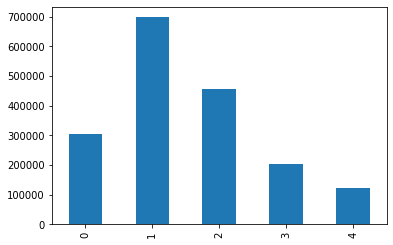

In [123]:
pd.Series(label_data).value_counts().sort_index().plot.bar()

In [124]:
intent_label_size = len(idx_label)
intent_label_size

5

### 의도 데이터에 대한 전처리

In [125]:
data_X =  [mecab.morphs(sentence) for sentence in final_df["question"]]
data_X[:3]


[['210416', 'KI', '취소', '할게요'],
 ['210416', 'PV', '취소', '할래'],
 ['역삼', '스타', '호텔', '부산', '2', '호', '선', '벡스코', '역', '빈', '방', '있', '어', '?']]

질문 최대 길이:  26
질문 평균 길이:  8.65997154944462


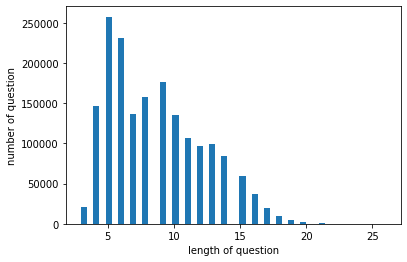

In [126]:
print("질문 최대 길이: ", max(len(sentence) for sentence in data_X))
print("질문 평균 길이: ", np.mean([len(sentence) for sentence in data_X]))
plt.hist([len(sentence) for sentence in data_X], bins = 50)
plt.xlabel("length of question")
plt.ylabel("number of question")
plt.show()

In [127]:
max_len = max(len(sentence) for sentence in data_X)
max_len

26

In [128]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_X)

In [129]:
X_data = tokenizer.texts_to_sequences(data_X)
X_data[:5]

[[95, 683, 15, 126],
 [95, 684, 15, 22],
 [293, 294, 11, 26, 49, 34, 35, 84, 152, 45, 2, 3, 4, 1],
 [96, 685, 15, 126],
 [295, 263, 296, 84, 6, 5, 7, 63, 38, 3, 4, 1]]

In [130]:
X_data = pad_sequences(sequences=X_data, maxlen=max_len)
X_data[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  95, 683,  15, 126],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  95, 684,  15,  22],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 293,
        294,  11,  26,  49,  34,  35,  84, 152,  45,   2,   3,   4,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  96, 685,  15, 126],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 295, 263, 296,  84,   6,   5,   7,  63,  38,   3,   4,   1]],
      dtype=int32)

### 학습 데이터와 테스트 데이터 분리

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_data, label_data, test_size = 0.2, random_state = 1)

### 원핫 인코딩

In [132]:
y_train = to_categorical(y_train, num_classes=intent_label_size)
y_test = to_categorical(y_test, num_classes=intent_label_size)

In [133]:
y_train[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [134]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

1401

### 의도 분류기 학습

In [135]:
import pickle
from keras.layers import Dense, Embedding, GRU
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [136]:
# model = Sequential()
# model.add(Embedding(input_dim = vocab_size,output_dim = 128))
# model.add(GRU(units = 128))
# model.add(Dense(units = intent_label_size, activation = "softmax"))

model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(GRU(128))
model.add(Dense(intent_label_size, activation='softmax'))

In [139]:
path = '../gdrive/MyDrive/Colab Notebooks/'
es = EarlyStopping(monitor = 'val_loss',patience= 4, verbose = 1, mode = 'min')
mc = ModelCheckpoint(filepath = path + "best_intent_model.h5",monitor = 'val_acc', save_best_only=True, mode = 'max',verbose = 1)

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ['acc'])
history = model.fit(x = X_train, y= y_train, batch_size=128, epochs =5, callbacks = [mc,es],validation_split = 0.2)

Train on 1140954 samples, validate on 285239 samples
Epoch 1/5
1140954/1140954 [==============================] - 231s 203us/step - loss: 1.1935e-07 - acc: 1.0000 - val_loss: 1.1926e-07 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to ../gdrive/MyDrive/Colab Notebooks/best_intent_model.h5
Epoch 2/5
1140954/1140954 [==============================] - 230s 202us/step - loss: 1.1923e-07 - acc: 1.0000 - val_loss: 1.1923e-07 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/5
1140954/1140954 [==============================] - 229s 201us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 1.1922e-07 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/5
1140954/1140954 [==============================] - 229s 201us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/5
1140954/1140954 [==============================] - 230s 

### 모델 저장 및 로드

In [140]:
path = '../gdrive/MyDrive/Colab Notebooks/'
loaded_model = load_model(path + 'best_intent_model.h5')
print(f"테스트 정확도: {loaded_model.evaluate(X_test,y_test)[1]*100:.2f}%")

356549/356549 [==============================] - 65s 182us/step
테스트 정확도: 100.00%


In [116]:
loaded_model = load_model('best_intent_model.h5')
print(f"테스트 정확도: {loaded_model.evaluate(X_test,y_test)[1]*100:.2f}%")

356549/356549 [==============================] - 67s 188us/step
테스트 정확도: 100.00%


### 토크나이저 저장 및 로드

In [141]:
#saving
path = '../gdrive/MyDrive/Colab Notebooks/'
with open(path+'intent_tokenizer.pickle','wb') as handle:
  pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [142]:
#load
with open(path+'intent_tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

### 테스트

In [143]:
def predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence)
  encoded = loaded_tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  y_pred = loaded_model.predict(pad_new)
  y_pred = np.argmax(y_pred, axis = -1)
  return idx_label[y_pred[0]]


In [144]:
predict("100000 아래로 하운드호텔 기장일광점 강북구 이용 가능한 방 있어??")

'예약'

In [145]:
predict("하운드 호텔 반려견 동반해도 돼?")

'정보'

In [146]:
predict("예약 취소해줘")

'취소'

In [147]:
predict("예약 시간 바꿔줘")

'변경'

## 개체명 인식 데이터 만들기

In [154]:
reservation_df = final_df[final_df["intent"]== "예약"].reset_index(drop=True)
change_df = final_df[final_df["intent"]== "변경"].reset_index(drop=True)
cancellation_df = final_df[final_df["intent"]== "취소"].reset_index(drop=True)
confirmation_df = final_df[final_df["intent"]== "확인"].reset_index(drop=True)
information_df = final_df[final_df["intent"]== "정보"].reset_index(drop=True)

In [155]:
reservation_df

,question,intent
0,역삼 스타 호텔 부산2호선 벡스코역 빈 방 있어?,예약
1,썸 무인텔 홍대거리 이용 가능한 방 있어?,예약
2,100000 밑으로 제임스 블루 호스텔 국제시장 이용 가능한 방 있어?,예약
3,100000 밑으로 에이치에비뉴 호텔 건대 성수 강릉 정동진 해돋이공원 이용 가능한...,예약
4,이가한옥 대구 내일 이용 가능해?,예약
...,...,...
697783,100000 이하 스터번호텔 동대구역 이용 가능한 방 있어?,예약
697784,히든밸리 펜션 곽지 해수욕장 모레 방 있어?,예약
697785,100000 미만 스터번호텔 서울 이용 가능한 방 있어?,예약
697786,100000원 미만 캠퍼스모텔 주문진항 이용 가능한 방 있어?,예약


In [157]:
print(hotel_list)
print("*"*100)
print(location_list)

['신라스테이 광화문', '신라스테이 역삼', '글래드 여의도', '글래드 강남 코엑스센터', '신라스테이 서대문', '신라스테이 서초', '나인트리 프리미어 호텔 인사동', '나인트리 프리미어 호텔 명동 2', '글래드 마포', 'L7 강남 바이 롯데', '오라카이 청계산 호텔', '시그니엘 서울', '신라스테이 삼성', '인터컨티넨탈 서울 코엑스', '롯데시티호텔 명동', '호텔 안테룸 서울', '호텔 스카이파크 킹스타운 동대문', '신라스테이 마포', '라마다 서울 호텔', '서울가든호텔', '서울 신라 호텔', '롯데시티호텔 구로', '신라스테이 구로', '오라카이 대학로 호텔', '나인트리 호텔 동대문', '라마다 서울 신도림', '티마크 그랜드 호텔 명동', '페어필드 바이 메리어트 서울', '호텔 리베라 서울', '노보텔 앰배서더 서울 용산', '그랜드 인터컨티넨탈 서울 파르나스', '쉐라톤 서울 디큐브시티 호텔', '오클라우드 호텔', '롯데 호텔 월드', '라마다 앙코르 서울 마곡', '그랜드 하얏트 서울', '임피리얼 팰리스 서울', '몬드리안 서울 이태원', 'L7 홍대 바이 롯데', '메이필드 호텔 서울', '호텔 더 디자이너스 서울역점', '콘래드 서울 호텔', '롯데시티호텔 마포', '호텔 루체브릿지', '오라카이 인사동 스위트', '아리랑힐 호텔 동대문', '도미인 서울 강남', '레스케이프 호텔', '스탠포드 호텔 서울', '롯데시티호텔 김포공항', 'PJ 호텔 명동 (피제이 호텔)', '그랜드 워커힐 서울 (구, 쉐라톤 그랜드 워커힐 서울)', '노보텔 스위트 앰배서더 서울 용산', '라이즈 오토그래프 컬렉션 바이 메리어트', '홀리데이 인 익스프레스 서울 홍대', '로사나 부띠끄 비즈니스 호텔', '호텔 인 9 강남', '호텔 파크하비오', '호텔 페이토 삼성', '로얄스퀘어호텔 서울', '서머셋 팰리스 서울', '코리아나 호텔', '오크우드 프리미어 코엑스센터', '노보텔 앰배서더 서울 동대문', '호텔 엠펠리체', '프리마 

In [171]:
for i in range(100):
  print(hotel_list[i])
  print(mecab.morphs(hotel_list[i]))
  print("*"*100)

신라스테이 광화문
['신라스테이', '광화문']
****************************************************************************************************
신라스테이 역삼
['신라스테이', '역삼']
****************************************************************************************************
글래드 여의도
['글래드', '여의도']
****************************************************************************************************
글래드 강남 코엑스센터
['글래드', '강남', '코엑스센터']
****************************************************************************************************
신라스테이 서대문
['신라스테이', '서대문']
****************************************************************************************************
신라스테이 서초
['신라스테이', '서초']
****************************************************************************************************
나인트리 프리미어 호텔 인사동
['나인트리', '프리미어', '호텔', '인사동']
****************************************************************************************************
나인트리 프리미어 호텔 명동 2
['나인트리', '프리미어', '호텔', '명동', '2']
*******************************

In [234]:
hoetel_list_words = set(word for sample in hotel_list for word in mecab.morphs(sample))
location_list_words = set(word for sample in location_list for word in mecab.morphs(sample))

In [236]:
tokenized_sequences = []
label_sequences = []

for sample in reservation_df["question"].to_list():
  temp_sample = []
  tokenized_sample = mecab.morphs(sample)
  for word in tokenized_sample:
    try:
      if int(word) >=10000:
        temp_sample.append("PRI")
    except:
      if word in hoetel_list_words:
        temp_sample.append("HOT")
      elif word in location_list_words:
        temp_sample.append("LOC")
      else:
        temp_sample.append("O")

  
  tokenized_sequences.append(tokenized_sample)
  label_sequences.append(temp_sample)

for i in range(10):
  print("질문: ", reservation_df["question"].to_list()[i])
  print("토큰화: ", tokenized_sequences[i])
  print("라벨링: ", label_sequences[i])
  print("*"*100)

질문:  브라운호텔 한라산 국립공원 방 있어?
토큰화:  ['브라운호텔', '한라산', '국립', '공원', '방', '있', '어', '?']
라벨링:  ['HOT', 'LOC', 'LOC', 'LOC', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문:  브라운호텔 강릉 경포대 방 있어?
토큰화:  ['브라운호텔', '강릉', '경포대', '방', '있', '어', '?']
라벨링:  ['HOT', 'HOT', 'HOT', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문:  100000원 아래로 니트 하우스 강릉 경포대 이용 가능한 방 있어?
토큰화:  ['100000', '원', '아래', '로', '니트', '하우스', '강릉', '경포대', '이용', '가능', '한', '방', '있', '어', '?']
라벨링:  ['PRI', 'HOT', 'O', 'HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'O', 'O', 'HOT', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문:  비스타 워커힐 서울 (구, W 서울 워커힐) 홍대거리 빈 방 있어?
토큰화:  ['비스타', '워커힐', '서울', '(', '구', ',', 'W', '서울', '워커힐', ')', '홍대', '거리', '빈', '방', '있', '어', '?']
라벨링:  ['HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'HOT', '